<a href="https://colab.research.google.com/github/falseywinchnet/PyITD/blob/main/FullyConvexTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
"""
Prepare the Shakespeare dataset for character-level language modeling.
So instead of encoding with GPT-2 BPE tokens, we just map characters to ints.
Will save train.bin, val.bin containing the ids, and meta.pkl containing the
encoder and decoder and some other related info.
"""
import os
import pickle
import requests
import numpy as np
import os
from pathlib import Path

try:
    base_dir = Path(__file__).parent
except NameError:
    base_dir = Path(os.getcwd())  # fallback if __file__ is not defined (e.g. in REPL)
# download the tiny shakespeare dataset
input_file_path = os.path.join(os.path.dirname(base_dir), 'input.txt')
if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)

with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# create the train and test splits
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

# encode both to integers
train_ids = encode(train_data)
val_ids = encode(val_data)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

# export to bin files
train_ids = np.array(train_ids, dtype=np.uint16)
val_ids = np.array(val_ids, dtype=np.uint16)
train_ids.tofile(os.path.join(os.path.dirname(base_dir), 'train.bin'))
val_ids.tofile(os.path.join(os.path.dirname(base_dir), 'val.bin'))

# save the meta information as well, to help us encode/decode later
meta = {
    'vocab_size': vocab_size,
    'itos': itos,
    'stoi': stoi,
}
with open(os.path.join(os.path.dirname(base_dir), 'meta.pkl'), 'wb') as f:
    pickle.dump(meta, f)

length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
train has 1,003,854 tokens
val has 111,540 tokens


#if you use my ideas, please credit me, dont just steal
joshuah.rainstar@gmail.com


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class TighteningTanh(nn.Module):
    def __init__(self, p=0.5, kappa=1.0, gamma=2.0, s_min=0.48):
        super().__init__()
        self.p = p
        self.kappa = kappa
        self.gamma = gamma
        self.s_min = s_min

    def forward(self, x):
        # x: any shape
        a = x.abs()
        # avoid log(0)
        t = torch.log(a + 1e-12) + self.p * torch.log(torch.tanh(a) + 1e-12)
        base = x.sign() * torch.exp(t)
        clamp = self.s_min + (1 - self.s_min) / (1 + (a / self.kappa) ** self.gamma)
        return base * clamp


class Gate(nn.Module):
    def __init__(self, embed_dim, **tanh_kwargs):
        super().__init__()
        self.proj = nn.Linear(embed_dim, 1)
        self.act  = TighteningTanh(**tanh_kwargs)
    def forward(self, x):
        # x: (B,S,embed)
        g = self.proj(x)           # (B,S,1)
        return torch.relu(self.act(g))  # clamp ≥0

class ICNN(nn.Module):
    """
    Input-Convex Neural Network module.
    """
    def __init__(self, input_dim, hidden_dims):
        super().__init__()
        self.V = nn.Linear(input_dim, hidden_dims[0], bias=True)
        self.U = nn.Linear(hidden_dims[0], hidden_dims[0], bias=False)
        self.hidden = nn.ModuleList(
            nn.Linear(hidden_dims[i], hidden_dims[i+1], bias=True)
            for i in range(len(hidden_dims)-1)
        )
        nn.init.uniform_(self.U.weight, a=0.0, b=0.01)

    def forward(self, x):
        z = F.relu(self.V(x))
        z = F.relu(self.U(z) + z)
        for layer in self.hidden:
            z = F.relu(layer(z))
        return z.mean(dim=-1, keepdim=True)

class HullModule(nn.Module):
    """
    Constructs a convex‐hull via log‐sum‐exp over gated ICNN petals.
    Each petal sees inputs scaled by a non‐negative gate (TighteningTanh‐based),
    preserving convexity in the petal's weights.
    """
    def __init__(self, input_dim, hidden_dims, petals, beta=1.0, tanh_kwargs=None):
        super().__init__()
        # petals: a list of convex ICNN modules
        self.petals = nn.ModuleList([ICNN(input_dim, hidden_dims) for _ in range(petals)])
        self.beta   = beta
        # gate: produces a positive scalar per input, using TighteningTanh
        self.gate = nn.Sequential(
            nn.Linear(input_dim, 1, bias=True),
            TighteningTanh(),
            nn.ReLU(),              # clamp ≥ 0
        )

    def forward(self, x):
        # x: (..., input_dim)
        # 1) compute a positive gate per example
        g = self.gate(x)          # (..., 1), ≥0
        # 2) scale inputs into each petal
        x_scaled = x * g          # broadcasting over last dim
        # 3) compute each petal’s score
        scores = torch.stack([p(x_scaled) for p in self.petals], dim=-1)  # (..., petals)
        # 4) log‐sum‐exp hull
        return (1.0 / self.beta) * torch.logsumexp(self.beta * scores, dim=-1, keepdim=False)

class OmniHullSelfAttention(nn.Module):
    def __init__(self, embed_dim, heads, petals, beta=1.0):
        super().__init__()
        self.heads = heads
        self.d_k = embed_dim // heads
        self.W_Q = nn.Linear(embed_dim, embed_dim, bias=False)
        self.W_K = nn.Linear(embed_dim, embed_dim, bias=False)
        self.W_V = nn.Linear(embed_dim, embed_dim, bias=False)
        self.W_O = nn.Linear(embed_dim, embed_dim, bias=False)
        self.hull = HullModule(self.d_k * 2, [self.d_k * 2], petals, beta)

    def forward(self, x):
        B, S, E = x.size()
        q_raw = self.W_Q(x)
        k_raw = self.W_K(x)
        v = self.W_V(x)
        positions = torch.arange(S, device=x.device).float()
        theta = positions.unsqueeze(1)
        cos_t = torch.cos(theta)
        sin_t = torch.sin(theta)
        q_rope = q_raw * cos_t.view(1, S, 1) - torch.roll(q_raw, shifts=1, dims=-1) * sin_t.view(1, S, 1)
        k_rope = k_raw * sin_t.view(1, S, 1) + torch.roll(k_raw, shifts=1, dims=-1) * cos_t.view(1, S, 1)
        qh = q_rope.view(B, S, self.heads, self.d_k)
        kh = k_rope.view(B, S, self.heads, self.d_k)
        vh = v.view(B, S, self.heads, self.d_k)
                    # DEBUG — print shapes

        outputs = []
        for h in range(self.heads):
            feat  = torch.cat([qh[:,:,h,:], kh[:,:,h,:]], dim=-1)
            score = self.hull(feat)                # expect (B, S, 1)
            score = score.squeeze(-1)              # expect (B, S)
            weight = F.softmax(score / (self.d_k**0.5), dim=-1).unsqueeze(-1)  # expect (B, S, 1)
            head_v = vh[:,:,h,:]                   # expect (B, S, d_k)

            out = weight * head_v   # should broadcast (B,S,1)*(B,S,d_k)->(B,S,d_k)
            outputs.append(out)
        concat = torch.cat(outputs, dim=-1)
        return self.W_O(concat)

class OmniHullBlock(nn.Module):
    def __init__(self, embed_dim, heads, petals, beta):
        super().__init__()
        self.attn = OmniHullSelfAttention(embed_dim, heads, petals, beta)
        self.hull_mlp = HullModule(embed_dim, [embed_dim * 2, embed_dim], petals, beta)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.hull_mlp(self.ln2(x))
        return x

class OmniHullGPT(nn.Module):
    """
    NanoGPT-style model with recursive convex-hull ICNN modules and RoPE.
    """
    def __init__(self, vocab_size, embed_dim, depth, heads, petals, beta=1.0):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.blocks = nn.ModuleList([
            OmniHullBlock(embed_dim, heads, petals, beta)
            for _ in range(depth)
        ])
        self.ln_f = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, vocab_size, bias=False)

    def forward(self, idx):
        x = self.token_emb(idx)
        for block in self.blocks:
            x = block(x)
        logits = self.head(self.ln_f(x))
        return logits

# Example instantiation:
# model = OmniHullGPT(vocab_size=50257, embed_dim=512, depth=6, heads=8, petals=4, beta=2.0)


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class TighteningTanh(nn.Module):
    def __init__(self, p=0.5, kappa=1.0, gamma=2.0, s_min=0.48):
        super().__init__()
        self.p = p
        self.kappa = kappa
        self.gamma = gamma
        self.s_min = s_min

    def forward(self, x):
        # x: any shape
        a = x.abs()
        # avoid log(0)
        t = torch.log(a + 1e-12) + self.p * torch.log(torch.tanh(a) + 1e-12)
        base = x.sign() * torch.exp(t)
        clamp = self.s_min + (1 - self.s_min) / (1 + (a / self.kappa) ** self.gamma)
        return base * clamp


class Gate(nn.Module):
    def __init__(self, embed_dim, **tanh_kwargs):
        super().__init__()
        self.proj = nn.Linear(embed_dim, 1)
        self.act  = TighteningTanh(**tanh_kwargs)
    def forward(self, x):
        # x: (B,S,embed)
        g = self.proj(x)           # (B,S,1)
        return torch.relu(self.act(g))  # clamp ≥0

class ICNN(nn.Module):
    """
    Input-Convex Neural Network module.
    """
    def __init__(self, input_dim, hidden_dims):
        super().__init__()
        self.V = nn.Linear(input_dim, hidden_dims[0], bias=True)
        self.U = nn.Linear(hidden_dims[0], hidden_dims[0], bias=False)
        self.hidden = nn.ModuleList(
            nn.Linear(hidden_dims[i], hidden_dims[i+1], bias=True)
            for i in range(len(hidden_dims)-1)
        )
        nn.init.uniform_(self.U.weight, a=0.0, b=0.01)

    def forward(self, x):
        z = F.relu(self.V(x))
        z = F.relu(self.U(z) + z)
        for layer in self.hidden:
            z = F.relu(layer(z))
        return z.mean(dim=-1, keepdim=True)

class HullModule(nn.Module):
    """
    Constructs a convex‐hull via log‐sum‐exp over gated ICNN petals.
    Each petal sees inputs scaled by a non‐negative gate (TighteningTanh‐based),
    preserving convexity in the petal's weights.
    """
    def __init__(self, input_dim, hidden_dims, petals, beta=1.0, tanh_kwargs=None):
        super().__init__()
        # petals: a list of convex ICNN modules
        self.petals = nn.ModuleList([ICNN(input_dim, hidden_dims) for _ in range(petals)])
        self.beta   = beta
        # gate: produces a positive scalar per input, using TighteningTanh
        self.gate = nn.Sequential(
            nn.Linear(input_dim, 1, bias=True),
            TighteningTanh(),
            nn.ReLU(),              # clamp ≥ 0
        )

    def forward(self, x):
        # x: (..., input_dim)
        # 1) compute a positive gate per example
        g = self.gate(x)          # (..., 1), ≥0
        # 2) scale inputs into each petal
        x_scaled = x * g          # broadcasting over last dim
        # 3) compute each petal’s score
        scores = torch.stack([p(x_scaled) for p in self.petals], dim=-1)  # (..., petals)
        # 4) log‐sum‐exp hull
        return (1.0 / self.beta) * torch.logsumexp(self.beta * scores, dim=-1, keepdim=False)

class OmniHullSelfAttention(nn.Module):
    def __init__(self, embed_dim, heads, petals, beta=1.0):
        super().__init__()
        self.heads = heads
        self.d_k = embed_dim // heads
        self.W_Q = nn.Linear(embed_dim, embed_dim, bias=False)
        self.W_K = nn.Linear(embed_dim, embed_dim, bias=False)
        self.W_V = nn.Linear(embed_dim, embed_dim, bias=False)
        self.W_O = nn.Linear(embed_dim, embed_dim, bias=False)
        self.hull = HullModule(self.d_k * 2, [self.d_k * 2], petals, beta)

    def forward(self, x):
        B, S, E = x.size()
        q_raw = self.W_Q(x)
        k_raw = self.W_K(x)
        v = self.W_V(x)
        positions = torch.arange(S, device=x.device).float()
        theta = positions.unsqueeze(1)
        cos_t = torch.cos(theta)
        sin_t = torch.sin(theta)
        q_rope = q_raw * cos_t.view(1, S, 1) - torch.roll(q_raw, shifts=1, dims=-1) * sin_t.view(1, S, 1)
        k_rope = k_raw * sin_t.view(1, S, 1) + torch.roll(k_raw, shifts=1, dims=-1) * cos_t.view(1, S, 1)
        qh = q_rope.view(B, S, self.heads, self.d_k)
        kh = k_rope.view(B, S, self.heads, self.d_k)
        vh = v.view(B, S, self.heads, self.d_k)
                    # DEBUG — print shapes

        outputs = []
        for h in range(self.heads):
            feat  = torch.cat([qh[:,:,h,:], kh[:,:,h,:]], dim=-1)
            score = self.hull(feat)                # expect (B, S, 1)
            score = score.squeeze(-1)              # expect (B, S)
            weight = F.softmax(score / (self.d_k**0.5), dim=-1).unsqueeze(-1)  # expect (B, S, 1)
            head_v = vh[:,:,h,:]                   # expect (B, S, d_k)

            out = weight * head_v   # should broadcast (B,S,1)*(B,S,d_k)->(B,S,d_k)
            outputs.append(out)
        concat = torch.cat(outputs, dim=-1)
        return self.W_O(concat)

class OmniHullBlock(nn.Module):
    def __init__(self, embed_dim, heads, petals, beta):
        super().__init__()
        self.attn = OmniHullSelfAttention(embed_dim, heads, petals, beta)
        self.hull_mlp = HullModule(embed_dim, [embed_dim * 2, embed_dim], petals, beta)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.hull_mlp(self.ln2(x))
        return x

class OmniHullGPT(nn.Module):
    """
    NanoGPT-style model with recursive convex-hull ICNN modules and RoPE.
    """
    def __init__(self, vocab_size, embed_dim, depth, heads, petals, beta=1.0):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.blocks = nn.ModuleList([
            OmniHullBlock(embed_dim, heads, petals, beta)
            for _ in range(depth)
        ])
        self.ln_f = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, vocab_size, bias=False)

    def forward(self, idx):
        x = self.token_emb(idx)
        for block in self.blocks:
            x = block(x)
        logits = self.head(self.ln_f(x))
        return logits

# Example instantiation:
# model = OmniHullGPT(vocab_size=50257, embed_dim=512, depth=6, heads=8, petals=4, beta=2.0)


In [71]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from torch.optim.optimizer import Optimizer
device    = 'cuda' if torch.cuda.is_available() else 'cpu'

@torch.jit.script
def wolf_update(p: torch.Tensor,
                g: torch.Tensor,
                state_p: torch.Tensor,
                lr: float):
    # define your constants here instead of capturing them
    etcerta: float = 0.367879441
    et:      float = 1.0 - etcerta

    # same logic as before
    update    = state_p * et + g * etcerta
    new_state = state_p * et + update * etcerta
    sign_agree = torch.sign(update) * torch.sign(g)
    update    = update + (torch.rand_like(update)*2 - 1) * etcerta * update
    p_new     = torch.where(sign_agree > 0, p - lr * update, p)
    return p_new, new_state

class Wolf(Optimizer):
    def __init__(self, params, lr=1e-3):
        defaults = dict(lr=lr)
        super().__init__(params, defaults)
        for group in self.param_groups:
            for p in group['params']:
                self.state[p]['p'] = torch.zeros_like(p)

    @torch.no_grad()
    def step(self, closure=None):
        loss = closure() if closure is not None else None
        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                state_p = self.state[p]['p']
                p_new, new_state = wolf_update(p.data, p.grad, state_p, lr)
                p.data.copy_(p_new)
                state_p.copy_(new_state)
        return loss

# 1) Load data and meta as before
data_dir  = os.path.dirname(base_dir)
train_ids = np.fromfile(os.path.join(data_dir, 'train.bin'), dtype=np.uint16)
val_ids   = np.fromfile(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16)
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# 2) Compute data‐marginal q[v]
counts = np.bincount(train_ids, minlength=vocab_size).astype(float)
q = torch.tensor(counts / counts.sum(), dtype=torch.float32, device=device)  # [V]

# 3) Dataset + DataLoader
class CharDataset(Dataset):
    def __init__(self, data, block_size):
        self.data = torch.from_numpy(data).long()
        self.block_size = block_size
    def __len__(self):
        return len(self.data) - self.block_size
    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

block_size = 512
train_loader = DataLoader(CharDataset(train_ids, block_size),
                          batch_size=16, shuffle=True, drop_last=True)
val_loader   = DataLoader(CharDataset(val_ids,   block_size),
                          batch_size=16, shuffle=False, drop_last=True)

# 4) Model, optimizer, loss
virgin     = OmniHullGPT(vocab_size=vocab_size, embed_dim=384, depth=4, heads=4, petals=4, beta=500.0)
print("Number of parameters: ", sum(p.numel() for p in virgin.parameters()))
model = torch.jit.script(virgin)
model.to(device)
optimizer = Wolf(model.parameters(), lr=0.5)#adam would explode at this training rate
criterion = nn.CrossEntropyLoss()

λ_ent         = 1e-4    # encourage weight diversification
λ_kl          = 0.5     # discourage mode collapse

# 6) Train / eval functions
def train_epoch():
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        # Forward
        logits = model(xb)                 # (B, T, V)
        B, T, V = logits.shape
        p = F.softmax(logits, dim=-1)      # (B, T, V)

        # 1) Standard CE
        ce_loss = criterion(logits.view(B*T, V),
                            yb.view(B*T))

        # 2) Entropy penalty
        ent = -(p * (p + 1e-12).log()).sum(dim=-1)  # (B, T)
        ent_loss = ent.mean()


        # 3) Marginal‐KL penalty
        p_m = p.mean(dim=(0,1))            # [V]
        kl_raw = (p_m * (p_m + 1e-12).log() - p_m * q.log()).sum()
        kl_loss = kl_raw ** 2

        # 4) Combined loss
        loss = ce_loss #+ λ_ent * ent_loss + λ_kl * kl_loss

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss.item())
        total_loss += loss.item()
    return total_loss / len(train_loader)

@torch.no_grad()
def eval_epoch():
    model.eval()
    total_loss = 0
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        B, T, V = logits.shape
        total_loss += criterion(logits.view(B*T,V),
                                yb.view(B*T)).item()
    return total_loss / len(val_loader)

# 7) Run training
num_epochs = 10
for epoch in range(1, num_epochs+1):
    train_loss = train_epoch()
    val_loss   = eval_epoch()
    print(f"Epoch {epoch:2d} | train: {train_loss:.4f} | val: {val_loss:.4f}")


Number of parameters:  8310540
4.372848033905029
4.325512409210205
4.254816055297852
4.189513206481934
4.131900310516357
4.05116081237793
3.95070219039917
3.8905832767486572
3.801283359527588
3.712617874145508
3.6342241764068604
3.583875894546509
3.537249803543091
3.446193218231201
3.4008078575134277
3.3913707733154297
3.3134872913360596
3.2868902683258057
3.274242639541626
3.2329134941101074
3.215283155441284
3.131978988647461
3.164942741394043
3.127150535583496
3.069317102432251
3.0848276615142822
3.0462348461151123
3.0260093212127686
3.0098845958709717
2.978264808654785
2.9392058849334717
2.9565048217773438
2.9644339084625244
2.930783271789551
2.9305579662323
2.95876407623291
2.8615970611572266
2.927164077758789
2.9066007137298584
2.9132072925567627
2.8835363388061523
2.866730213165283
2.8904781341552734
2.8378872871398926
2.84157657623291
2.8503878116607666
2.8301191329956055
2.811424732208252
2.821043014526367
2.8033533096313477
2.8267557621002197
2.8226728439331055
2.800169229507

KeyboardInterrupt: 

In [ ]:
optimizer = Wolf(model.parameters(), lr=1e-1)#adam would explode at this training rate
criterion = nn.CrossEntropyLoss()

λ_ent         = 1e-4    # encourage weight diversification
λ_kl          = 0.5     # discourage mode collapse

# 6) Train / eval functions
def train_epoch():
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        # Forward
        logits = model(xb)                 # (B, T, V)
        B, T, V = logits.shape
        p = F.softmax(logits, dim=-1)      # (B, T, V)

        # 1) Standard CE
        ce_loss = criterion(logits.view(B*T, V),
                            yb.view(B*T))

        # 2) Entropy penalty
        ent = -(p * (p + 1e-12).log()).sum(dim=-1)  # (B, T)
        ent_loss = ent.mean()


        # 3) Marginal‐KL penalty
        p_m = p.mean(dim=(0,1))            # [V]
        kl_raw = (p_m * (p_m + 1e-12).log() - p_m * q.log()).sum()
        kl_loss = kl_raw ** 2

        # 4) Combined loss
        loss = ce_loss + λ_ent * ent_loss + λ_kl * kl_loss

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss.item())
        total_loss += loss.item()
    return total_loss / len(train_loader)

@torch.no_grad()
def eval_epoch():
    model.eval()
    total_loss = 0
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        B, T, V = logits.shape
        total_loss += criterion(logits.view(B*T,V),
                                yb.view(B*T)).item()
    return total_loss / len(val_loader)

# 7) Run training
num_epochs = 10
for epoch in range(1, num_epochs+1):
    train_loss = train_epoch()
    val_loss   = eval_epoch()
    print(f"Epoch {epoch:2d} | train: {train_loss:.4f} | val: {val_loss:.4f}")

0.8744832873344421
0.8671879172325134
0.8726839423179626
0.8802876472473145
0.884606659412384
0.8451123237609863
0.8068631887435913
0.8492572903633118
0.8077354431152344
0.8070570230484009
0.8290683627128601
0.779879093170166
0.7885192036628723
0.84754478931427
0.7718552350997925
0.8194792866706848
0.798578143119812
0.7893304228782654
0.7562169432640076
0.792137861251831
0.7558127045631409
0.7953327894210815
0.7965782880783081
0.7290084362030029
0.774318277835846
0.8067860007286072
0.7345098257064819
0.7615070939064026
0.7155083417892456
0.791839599609375
0.6729615330696106
0.7325694561004639
0.7153492569923401
0.7079640626907349
0.7433766722679138
0.7113266587257385
0.7500835061073303
0.7850892543792725
0.7058526277542114
0.7237353324890137
0.7511070370674133
0.7066757678985596
0.7299737334251404
0.6797924637794495
0.6939865946769714
0.6783912181854248
0.7213645577430725
0.6658611297607422
0.6455279588699341
0.6174579858779907
0.6349901556968689
0.6628884673118591
0.6855146884918213
0

In [15]:
bcontext_str = "To be, or not to be,"
context_ids = torch.tensor([[ stoi[c] for c in bcontext_str ]],
                           dtype=torch.long)
context_ids = context_ids.to(device)

max_new_tokens = 200
temperature     = 1.0
top_k           = 25
block_size      = 128

generated = context_ids  # (1, T)

for _ in range(max_new_tokens):
    # only pass at most block_size tokens into the model
    input_ids = generated
    logits =model(input_ids)              # (1, T_cur, vocab_size)
    logits = logits[:, -1, :] / temperature

    if top_k is not None:
        v, _ = torch.topk(logits, top_k)
        logits[logits < v[:, [-1]]] = -1e10

    probs   = F.softmax(logits, dim=-1)
    next_id = torch.multinomial(probs, num_samples=1)  # (1,1)
    generated = torch.cat([generated, next_id], dim=1)

output_str = ''.join([itos[i] for i in generated[0].tolist()])
print(output_str)


To be, or not to be,
AN
TI ine thin din t ther ay t led h iss an orthitore o we n tvead, t pisponvDALwile, wy atWhe orormd gedisth s buDFone I shand yomat ouse dyoovesou. winsore founoud the, yallll she's anershth
Smyodo


In [38]:
import torch
import torch.nn.functional as F
import numpy as np


import torch
import torch.nn.functional as F
import numpy as np
def hull_scores(self, x):
    """
    Compute raw petal scores for input x using existing model parameters.
    x: Tensor of shape (batch_size, input_dim)
    Returns: Tensor of shape (batch_size, petals)
    """
    # replicate gate + scaling from HullModule.forward, without log-sum-exp
    g = self.gate(x)            # (batch_size, 1)
    x_scaled = x * g            # (batch_size, input_dim)
    # stack scores from each petal
    scores = torch.stack([p(x_scaled).squeeze(-1) for p in self.petals], dim=1)  # (batch_size, petals)
    return scores

# Monkey-patch the method into HullModule
HullModule.scores = hull_scores
class BetaOptimizer:
    def __init__(self, hull_module, d_vals, X, device='cpu'):
        """
        hull_module: a HullModule
        d_vals: array-like length P (petal count)
        X: Tensor of shape (N, input_dim) matching hull_module input
        """
        self.hull = hull_module.to(device)
        self.d = torch.tensor(d_vals, device=device).float()
        self.X = X.to(device)
        self.device = device

    def evaluate(self, beta):
        f = self.hull.scores(self.X)           # shape (N, P)
        w = F.softmax(beta * f, dim=1)         # shape (N, P)
        return (w * self.d).sum(dim=1).mean().item()

    def find_beta_max(self, threshold=0.999, beta_start=1.0, max_beta=1e6):
        f = self.hull.scores(self.X)           # precompute scores
        beta = beta_start
        while beta <= max_beta:
            w = F.softmax(beta * f, dim=1)
            if float(w.max(dim=1)[0].mean()) >= threshold:
                return beta
            beta *= 2
        return max_beta

    def golden_section_search(self, beta_min=1e-16, beta_max=None, tol=1e-3, max_iter=30):
        if beta_max is None:
            beta_max = self.find_beta_max()
        gr = (np.sqrt(5) + 1) / 2
        a, b = beta_min, beta_max
        c = b - (b - a) / gr
        d = a + (b - a) / gr
        fc, fd = self.evaluate(c), self.evaluate(d)

        for _ in range(max_iter):
            if (b - a) < tol:
                break
            if fc < fd:
                b, fd = d, fc
                d = c
                c = b - (b - a) / gr
                fc = self.evaluate(c)
            else:
                a, fc = c, fd
                c = d
                d = a + (b - a) / gr
                fd = self.evaluate(d)

        beta_star = (a + b) / 2
        return beta_star, self.evaluate(beta_star)


def optimize_all_hulls(model, d_vals_generator, X_generator, device='cpu'):
    """
    Iterate over all HullModules in OmniHullGPT, generating X per-hull.

    Args:
        model: OmniHullGPT instance
        d_vals_generator: fn(hull, block_idx, part) -> array-like of length P
        X_generator:    fn(hull, block_idx, part) -> Tensor (N, input_dim)
        device: 'cpu' or 'cuda'
    Returns:
        List of dicts with keys: block, part, beta_star, cost_star
    """
    results = []
    for b_idx, block in enumerate(model.blocks):
        for part in ['attn', 'hull_mlp']:
            if part == 'attn':
                hull = block.attn.hull
            else:
                hull = block.hull_mlp

            # generate inputs and costs for this hull
            d_vals = d_vals_generator(hull, b_idx, part)
            X      = X_generator(hull, b_idx, part)

            optimizer = BetaOptimizer(hull, d_vals, X, device)
            beta_star, cost_star = optimizer.golden_section_search()
            results.append({
                'block': b_idx,
                'part': part,
                'beta_star': beta_star,
                'cost_star': cost_star
            })
    return results

# Example usage (not executed here):
def dummy_d_vals(hull, block_idx, part):
     P = len(hull.petals)
     return np.linspace(0.1, 1.0, P)

def random_X(hull, block_idx, part, N=128):
    dim = hull.petals[0].V.in_features
    return torch.randn(N, dim)
N, input_dim = 128, model.blocks[0].attn.hull.petals[0].V.in_features
X = torch.randn(N, input_dim)
results = optimize_all_hulls(model, dummy_d_vals, random_X, device='cpu')
for res in results:
    print(res)

{'block': 0, 'part': 'attn', 'beta_star': np.float64(65532.396078685975), 'cost_star': 0.2758922576904297}
{'block': 0, 'part': 'hull_mlp', 'beta_star': np.float64(143.40292348439417), 'cost_star': 0.5217301249504089}
{'block': 1, 'part': 'attn', 'beta_star': np.float64(1709.4852696925022), 'cost_star': 0.20512399077415466}
{'block': 1, 'part': 'hull_mlp', 'beta_star': np.float64(131071.9647750226), 'cost_star': 0.761249840259552}
{'block': 2, 'part': 'attn', 'beta_star': np.float64(16383.995596877825), 'cost_star': 0.2694746255874634}
{'block': 2, 'part': 'hull_mlp', 'beta_star': np.float64(2975.983309799004), 'cost_star': 0.1771697700023651}
{'block': 3, 'part': 'attn', 'beta_star': np.float64(0.004403122174816935), 'cost_star': 0.5500027537345886}
{'block': 3, 'part': 'hull_mlp', 'beta_star': np.float64(0.004403122174816935), 'cost_star': 0.5500040054321289}
{'block': 4, 'part': 'attn', 'beta_star': np.float64(65534.93787971994), 'cost_star': 0.24124465882778168}
{'block': 4, 'part'

In [39]:
def bootstrap_beta(hull, d_vals, X_generator, device, n_trials=20):
    betas = []
    for _ in range(n_trials):
        X   = X_generator(hull)
        opt = BetaOptimizer(hull, d_vals, X, device)
        b, _ = opt.golden_section_search()
        betas.append(b)
    return np.array(betas)

# Example for block 0 attn:
hull0 = model.blocks[0].attn.hull
d_vals0 = dummy_d_vals(hull0, 0, 'attn')
betas0 = bootstrap_beta(hull0, d_vals0, lambda h: random_X(h,0,'attn'), 'cpu', 30)

print("Block0-attn β* mean:", betas0.mean(), "std:", betas0.std())

Block0-attn β* mean: 57936.32097581424 std: 176856.96163276394


In [41]:
# 1) Prepare your hull, costs, and sample X once
hull0    = model.blocks[0].attn.hull
d_vals0  = dummy_d_vals(hull0, 0, 'attn')
X0       = random_X(hull0, 0, 'attn', N=512)   # larger N for stability

# 2) Instantiate your optimizer
opt0 = BetaOptimizer(hull0, d_vals0, X0, device='cpu')

# 3) Bootstrap β* estimates
import numpy as np

def bootstrap_beta(opt, n_trials=30):
    betas = []
    for _ in range(n_trials):
        # if you want fresh X each trial:
        X_trial = random_X(opt.hull, 0, 'attn', N=512)
        opt.X = X_trial.to(opt.device)
        b, _ = opt.golden_section_search()
        betas.append(b)
    return np.array(betas)

betas0 = bootstrap_beta(opt0, n_trials=30)
print("β* mean:", betas0.mean(), "std:", betas0.std())


β* mean: 39942.1557802269 std: 46080.58836050734


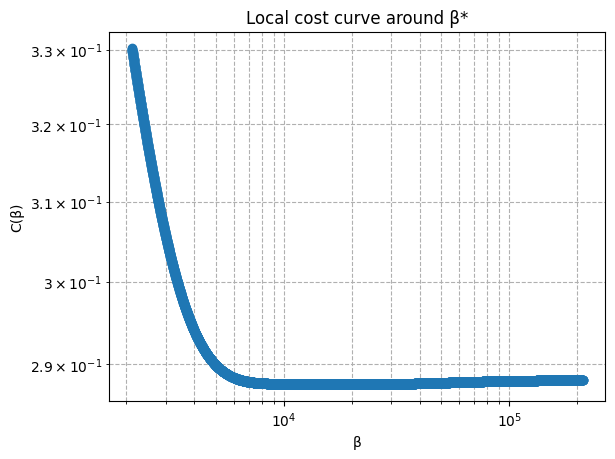

In [44]:
# get your best β once
b_star, _ = opt0.golden_section_search()

# sample points around log-space neighborhood
betas = np.logspace(np.log10(b_star) - 1,
                    np.log10(b_star) + 1,
                    num=5000)

# evaluate C(β) via opt0.evaluate
costs = [opt0.evaluate(b) for b in betas]

# plot (requires matplotlib)
import matplotlib.pyplot as plt

plt.figure()
plt.loglog(betas, costs, marker='o')
plt.xlabel('β')
plt.ylabel('C(β)')
plt.title('Local cost curve around β*')
plt.grid(True, which='both', ls='--')
plt.show()


In [45]:
# assume `betas` & `costs` are your sampled arrays
import numpy as np

ε = 0.005
C_min = np.min(costs)
threshold = C_min * (1 + ε)
knee_idx = next(i for i,c in enumerate(costs) if c <= threshold)
beta_knee = betas[knee_idx]
print(f"Knee β ≈ {beta_knee:.1e}, C = {costs[knee_idx]:.4f}")


Knee β ≈ 5.4e+03, C = 0.2890


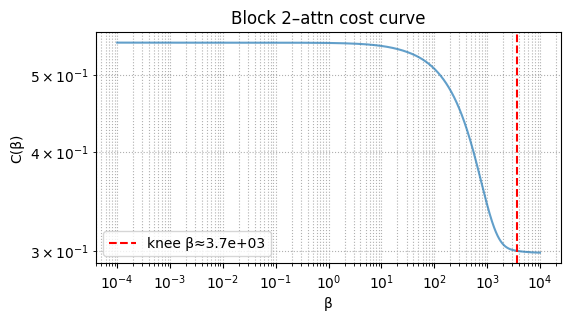

Block 2–attn knee: β≈3.7e+03, C=0.3001


In [67]:
import numpy as np
import matplotlib.pyplot as plt

def compute_knee_for_hull(hull, d_vals, X, device='cpu',
                          β_min=1e-3, β_max=1e6, n_points=5000, tol=0.005):
    """
    For a given HullModule, sample C(β) over a log-spaced grid,
    detect the elbow (knee) within tol-relative tolerance of the min.
    Returns (betas, costs, beta_knee, cost_knee).
    """
    # Prepare optimizer
    opt = BetaOptimizer(hull, d_vals, X, device=device)
    # Log-spaced grid
    betas = np.logspace(np.log10(β_min), np.log10(β_max), n_points)
    costs = [opt.evaluate(b) for b in betas]

    # Global minimum
    C_min = np.min(costs)
    threshold = C_min * (1 + tol)

    # Knee: first β where cost <= threshold
    knee_idx = next(i for i,c in enumerate(costs) if c <= threshold)
    beta_knee, cost_knee = betas[knee_idx], costs[knee_idx]

    # (Optional) visualize
    plt.figure(figsize=(6,3))
    plt.loglog(betas, costs, '-', alpha=0.7)
    plt.axvline(beta_knee, color='r', ls='--',
                label=f'knee β≈{beta_knee:.1e}')
    plt.title(f'Block {block_idx}–{part} cost curve')
    plt.xlabel('β'); plt.ylabel('C(β)')
    plt.legend(); plt.grid(which='both', ls=':')
    plt.show()

    return betas, costs, beta_knee, cost_knee

# --- Example: test block 3–attn ------------------------------------------

# 1) Select the hull
block_idx, part = 3, 'attn'
hull = model.blocks[block_idx].attn.hull

# 2) Regenerate or reuse your d_vals and X for this hull
d_vals_3 = dummy_d_vals(hull, block_idx, part)
X_3      = random_X(hull, block_idx, part, N=512)

# 3) Run the knee detection
betas3, costs3, β_knee3, C_knee3 = compute_knee_for_hull(
    hull, d_vals_3, X_3, device='cpu',
    β_min=1e-4, β_max=1e4,  # you can tighten the search window
    n_points=5000, tol=0.005
)

print(f"Block {block_idx}–{part} knee: β≈{β_knee3:.1e}, C={C_knee3:.4f}")


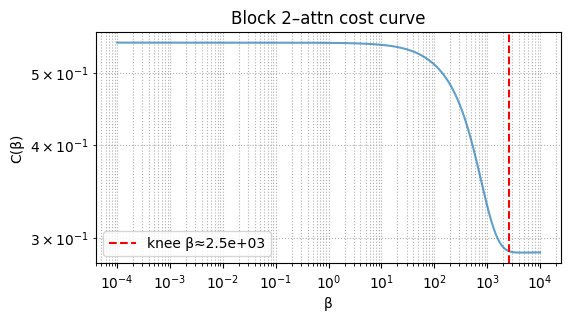

Block 2–attn knee: β≈2.5e+03, C=0.2879


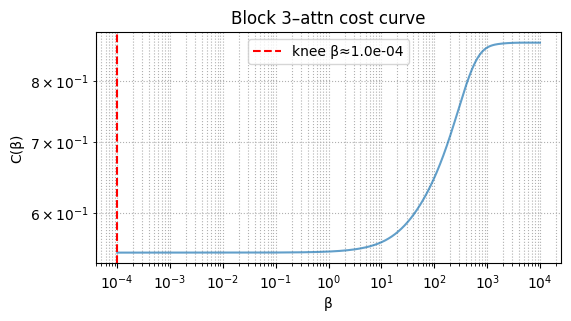

Block 3–attn knee: β≈1.0e-04, C=0.5500


{2: (np.float64(2548.4801559502575), 0.28787487745285034),
 3: (np.float64(0.0001), 0.5500001907348633)}

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assuming BetaOptimizer, compute_knee_for_hull, dummy_d_vals, and random_X are defined.

# Re-define compute_knee_for_hull to ensure standalone execution
def compute_knee_for_hull(hull, d_vals, X, device='cpu',
                          beta_min=1e-4, beta_max=1e4, n_points=5000, tol=0.005):
    """
    For a given HullModule, sample C(β) over a log-spaced grid,
    detect the elbow (knee) within tol-relative tolerance of the min.
    Returns (beta_knee, cost_knee).
    """
    opt = BetaOptimizer(hull, d_vals, X, device=device)
    betas = np.logspace(np.log10(beta_min), np.log10(beta_max), n_points)
    costs = [opt.evaluate(b) for b in betas]

    C_min = np.min(costs)
    threshold = C_min * (1 + tol)
    knee_idx = next(i for i, c in enumerate(costs) if c <= threshold)
    beta_knee = betas[knee_idx]
    cost_knee = costs[knee_idx]

    # Plot
    plt.figure(figsize=(6,3))
    plt.loglog(betas, costs, '-', alpha=0.7)
    plt.axvline(beta_knee, color='r', ls='--',
                label=f'knee β≈{beta_knee:.1e}')
    plt.title(f'Block {block_idx}–{part} cost curve')
    plt.xlabel('β')
    plt.ylabel('C(β)')
    plt.legend()
    plt.grid(which='both', ls=':')
    plt.show()

    return beta_knee, cost_knee

# Apply to hulls 2 and 3 (attn)
results = {}
for block_idx in [2, 3]:
    part = 'attn'
    hull = model.blocks[block_idx].attn.hull
    d_vals = dummy_d_vals(hull, block_idx, part)
    X = random_X(hull, block_idx, part, N=512)
    beta_knee, cost_knee = compute_knee_for_hull(
        hull, d_vals, X, device='cpu',
        beta_min=1e-4, beta_max=1e4, n_points=5000, tol=0.005
    )
    results[block_idx] = (beta_knee, cost_knee)
    print(f"Block {block_idx}–{part} knee: β≈{beta_knee:.1e}, C={cost_knee:.4f}")

results


In [69]:
import numpy as np
import matplotlib.pyplot as plt

def sample_cost_curve(hull, d_vals, X, beta_min, beta_max, n_points, device='cpu'):
    """
    Returns (betas, costs) for C(β) = E_x[ softmax(β f(x)) · d ].
    """
    opt = BetaOptimizer(hull, d_vals, X, device=device)
    betas = np.logspace(np.log10(beta_min), np.log10(beta_max), n_points)
    costs = np.array([opt.evaluate(b) for b in betas])
    return betas, costs

# --- Prepare data for blocks 2 and 3 (attn hulls) ---
block_idxs = [2, 3]
part = 'attn'
beta_min, beta_max, n_pts = 1e-4, 1e4, 5000

curves = {}
for b in block_idxs:
    hull = model.blocks[b].attn.hull
    d_vals = dummy_d_vals(hull, b, part)
    X      = random_X(hull, b, part, N=512)
    betas, costs = sample_cost_curve(hull, d_vals, X, beta_min, beta_max, n_pts)
    curves[b] = (betas, costs)

# --- Find intersection of C2(β) and C3(β) ---
b_grid, C2 = curves[2]
_,   C3 = curves[3]
diff = C2 - C3

# locate the first index where diff changes sign
idx = np.where(np.sign(diff[:-1]) != np.sign(diff[1:]))[0]
if len(idx) == 0:
    raise RuntimeError("No intersection found in [{}, {}]".format(beta_min, beta_max))

i = idx[0]
# linear interpolation between (b_i, diff_i) and (b_{i+1}, diff_{i+1})
b1, b2 = b_grid[i], b_grid[i+1]
d1, d2 = diff[i], diff[i+1]
# solve for beta at zero crossing: b = b1 - d1*(b2-b1)/(d2-d1)
beta_meet = b1 - d1 * (b2 - b1) / (d2 - d1)
cost_meet = np.interp(beta_meet, b_grid, C2)  # same for C3

print(f"Curves intersect at β ≈ {beta_meet:.3e}, C ≈ {cost_meet:.4f}")

# --- Optional: plot both curves and mark intersection ---
plt.figure(figsize=(6,3))
plt.loglog(b_grid, C2, label='Block 2–attn')
plt.loglog(b_grid, C3, label='Block 3–attn')
plt.axvline(beta_meet, color='k', ls='--', label=f'Intersection β≈{beta_meet:.1e}')
plt.scatter([beta_meet], [cost_meet], color='k')
plt.xlabel('β'); plt.ylabel('C(β)')
plt.legend(); plt.grid(which='both', ls=':')
plt.title('Intersection of Block 2 vs. Block 3 cost curves')
plt.show()


RuntimeError: No intersection found in [0.0001, 10000.0]

In [59]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import scipy.stats as stats
import ace_tools_open as tools

# Replace these with your actual model, X_generator, and d_vals_generator:
def dummy_d_vals(hull, block_idx, part):
    P = len(hull.petals)
    return np.linspace(0.1, 1.0, P)

def random_X(hull, block_idx, part, N=512):
    dim = hull.petals[0].V.in_features
    return torch.randn(N, dim)

# Prepare hull 3-attn
block_idx, part = 4, 'attn'
hull3 = model.blocks[block_idx].attn.hull
X_3 = random_X(hull3, block_idx, part, N=1024)
d_vals_3 = dummy_d_vals(hull3, block_idx, part)

# 1) Compute per-petal average score
scores_3 = hull3.scores(X_3)  # (N, P)
mean_scores = scores_3.mean(dim=0).cpu().detach().numpy()

# 2) DataFrame for inspection
df = pd.DataFrame({
    'petal': np.arange(len(mean_scores)),
    'mean_score': mean_scores,
    'd_val': d_vals_3
})
tools.display_dataframe_to_user("Block 4-attn: Mean Scores vs. d_vals", df)

# 3) Compute correlations
pearson_r, pearson_p = stats.pearsonr(mean_scores, d_vals_3)
spearman_r, spearman_p = stats.spearmanr(mean_scores, d_vals_3)

print(f"Pearson: r={pearson_r:.3f} (p={pearson_p:.2e})")
print(f"Spearman: rho={spearman_r:.3f} (p={spearman_p:.2e})")


Block 4-attn: Mean Scores vs. d_vals


Pearson: r=-1.000 (p=1.00e+00)
Spearman: rho=-1.000 (p=nan)


In [66]:
import numpy as np
from scipy.optimize import brentq

def find_cost_intersection(hull_A, hull_B, d_vals_A, d_vals_B,
                           X, beta_min=1e-4, beta_max=1e6,
                           device='cpu'):
    """
    Returns the β where C_A(β) == C_B(β), with
      C(β) = E_x[ softmax(β f(x)) · d ].

    hull_A, hull_B   : HullModule instances
    d_vals_A/B       : arrays of shape (P_A,) and (P_B,)
    X                : Tensor of shape (N, input_dim)
    beta_min, beta_max: search interval
    """
    # prepare optimizers
    optA = BetaOptimizer(hull_A, d_vals_A, X, device)
    optB = BetaOptimizer(hull_B, d_vals_B, X, device)

    # define difference
    def diff(β):
        return optA.evaluate(β) - optB.evaluate(β)

    # ensure we have a sign change on [beta_min, beta_max]
    fmin, fmax = diff(beta_min), diff(beta_max)
    if fmin * fmax > 0:
        raise RuntimeError(f"No crossing in [{beta_min},{beta_max}]: "
                           f"diff(min)={fmin:.3e}, diff(max)={fmax:.3e}")

    # find root
    β_star = brentq(diff, beta_min, beta_max)
    Cstar = optA.evaluate(β_star)  # == optB.evaluate(β_star)
    return β_star, Cstar

# --- Example usage for block 0 vs. block 3 (attn hulls) ---

# 1) pick your hulls
hull0 = model.blocks[0].attn.hull
hull3 = model.blocks[3].attn.hull

# 2) regenerate or reuse X and d_vals
X   = random_X(hull0, 0, 'attn', N=512)      # must match both hulls’ input dim
d0  = dummy_d_vals(hull0, 0, 'attn')
d3  = dummy_d_vals(hull3, 5, 'attn')

# 3) find their intersection
beta_meet, cost_meet = find_cost_intersection(
    hull0, hull3, d0, d3, X,
    beta_min=1e-4, beta_max=1e6,
    device='cpu'
)

print(f"Curves meet at β ≈ {beta_meet:.3e}, with C = {cost_meet:.4f}")


RuntimeError: No crossing in [0.0001,1000000.0]: diff(min)=-1.192e-07, diff(max)=-5.678e-01